In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import parmed as pmd
from paprika.analysis import fe_calc
from paprika.io import PaprikaEncoder, load_restraints
from paprika.restraints.utils import extract_guest_restraints

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.
/home/jsetiadi/mambaforge/envs/paprika-dev/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Calculate attachment free-energy

In [2]:
method = "ti-block"
restraints = load_restraints(filepath="../boresch/boresch_restraints.json")

In [3]:
free_energy = fe_calc()
free_energy.topology = "system.pdb"
free_energy.trajectory = "production.dcd"
free_energy.path = "../attach"
free_energy.restraint_list = restraints
free_energy.collect_data()
free_energy.fractions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
free_energy.methods = [method]
free_energy.ti_matrix = "diagonal"
free_energy.bootcycles = 1000
free_energy.compute_free_energy()
free_energy.compute_ref_state_work(restraints, state="initial")

/home/jsetiadi/mambaforge/envs/paprika-dev/lib/python3.10/site-packages/paprika/analysis.py:649: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data_points = [len(np.asarray(x).T) for x in self.simulation_data[phase]]
/home/jsetiadi/mambaforge/envs/paprika-dev/lib/python3.10/site-packages/paprika/analysis.py:973: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  force_constants_T = np.asarray(force_constants).T * force_units
/home/jsetiadi/mambaforge/envs/paprika-dev/lib/python3.10/site-packages/paprika/analysis.py:974: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  targets_T = np.asarray(targets).T * target_units
/home/jsetiadi/mambaforge/envs/paprika-dev/lib/python3.10/site-packages/paprika/analysis.py:1323: UserWarning: Converting restraint list to dictionary, make sure the restraints are listed in the order of [`r`, `theta`,`phi`, `alpha`, `beta`, `gamma`].
  w

In [8]:
results = free_energy.results
with open("../attach/results_attach.json", "w") as f:
    dumped = json.dumps(results, cls=PaprikaEncoder)
    f.write(dumped)

## Print free-energy results

In [5]:
def print_binding(results, method="ti-block"):
    fe_a = -1 * results["attach"][method]["fe"].magnitude
    sem_a = results["attach"][method]["sem"].magnitude
    fe_ref = -1 * results["ref_state_work"].magnitude

    print(f"Analysis - {method}")
    print("-" * 25)
    print(f"Attach free-energy    = {fe_a:6.2f} +/- {sem_a:0.2f} kcal/mol")
    print(f"Reference free-energy = {fe_ref:6.2f} kcal/mol")
    print("")


print_binding(results, method=method)

Analysis - ti-block
-------------------------
Attach free-energy    =  -3.24 +/- 0.07 kcal/mol
Reference free-energy =  11.34 kcal/mol



In [6]:
def get_fe_convergence(results, method="ti-block"):
    convergence = {}

    # Free energy
    attach = results["attach"][method]["fraction_fe"]
    convergence["fe_a"] = -1 * np.array([attach[i].magnitude for i in attach])
    convergence["fractions"] = np.array([i for i in attach])

    # Error
    attach = results["attach"][method]["fraction_sem"]
    convergence["sem_a"] = np.array([attach[i].magnitude for i in attach])

    return convergence


convergence = get_fe_convergence(results, method=method)

## Plot free-energy profile and convergence

/home/jsetiadi/mambaforge/envs/paprika-dev/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3444: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y, dtype=object)
/home/jsetiadi/mambaforge/envs/paprika-dev/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3483: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(err, dtype=object)


Text(0.5, 1.0, 'FE convergence')

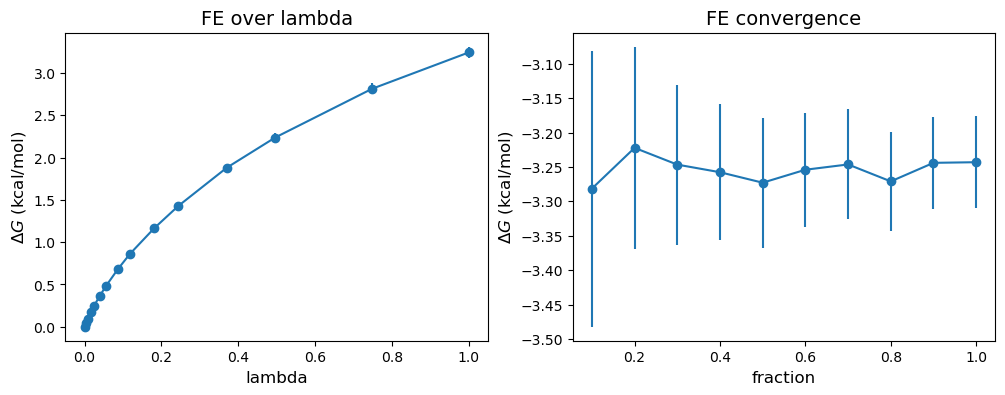

In [7]:
attach_string = (
    "0.00 0.40 0.80 1.60 2.40 4.00 5.50 8.65 11.80 18.10 24.40 37.00 49.60 74.80 100.00"
)
attach_fractions = [float(i) / 100 for i in attach_string.split()]

plt.figure(dpi=100, figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.errorbar(
    attach_fractions,
    results["attach"]["ti-block"]["fe_matrix"][0, :],
    yerr=results["attach"]["ti-block"]["sem_matrix"][0, :],
    fmt="-o",
)
plt.xlabel("lambda", fontsize=12)
plt.ylabel(r"$\Delta G$ (kcal/mol)", fontsize=12)
plt.title("FE over lambda", fontsize=14)

plt.subplot(1, 2, 2)
plt.errorbar(
    convergence["fractions"], convergence["fe_a"], yerr=convergence["sem_a"], fmt="o-"
)
plt.xlabel("fraction", fontsize=12)
plt.ylabel(r"$\Delta G$ (kcal/mol)", fontsize=12)
plt.title("FE convergence", fontsize=14)